# 📊 FPT Stock Price Prediction - EDA & Deep Dive Analysis

Notebook này thực hiện phân tích khám phá dữ liệu (EDA) chi tiết và đánh giá chuyên sâu về hiệu quả của các kỹ thuật **RevIN** và **HMM** dựa trên kết quả thực nghiệm (600+ submissions).

## Mục lục
1.  [Data Loading & Preprocessing](#1.-Data-Loading-&-Preprocessing)
2.  [Feature Engineering Analysis](#2.-Feature-Engineering-Analysis)
    *   Log Transformation
    *   Spread Features (HL/OC)
    *   Returns & Volatility
3.  [HMM Deep Dive](#3.-HMM-Deep-Dive)
    *   Regime Visualization (3 vs 4 components)
4.  [RevIN & Model Performance Deep Dive](#4.-RevIN-&-Model-Performance-Deep-Dive)
    *   Impact of RevIN
    *   Impact of HMM
    *   Correlation Analysis

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import os
import glob
import re

# Cấu hình hiển thị
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading & Preprocessing

In [69]:
# Load dữ liệu
df = pd.read_csv('data/FPT_train.csv')

# Xử lý cột Date (trong file csv là 'time')
if 'time' in df.columns:
    df.rename(columns={'time': 'Date'}, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Chuẩn hóa tên cột về dạng Title Case (Open, High, Low, Close, Volume) để tiện xử lý
df.rename(columns={
    'open': 'Open', 
    'high': 'High', 
    'low': 'Low', 
    'close': 'Close', 
    'volume': 'Volume'
}, inplace=True)

print(f"Data Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Data Shape: (1149, 6)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'symbol']


,Open,High,Low,Close,Volume,symbol
Date,,,,,,
2020-08-03,19.07,19.63,19.03,19.63,1392200,FPT
2020-08-04,19.89,20.01,19.76,19.91,1051310,FPT
2020-08-05,19.89,20.16,19.78,20.10,1328520,FPT
2020-08-06,20.10,20.21,19.97,20.01,1153660,FPT
2020-08-07,20.01,20.44,20.01,20.14,1283690,FPT


## 2. Feature Engineering Analysis

### 2.1 Log Transformation
Chúng ta sử dụng `np.log1p` để giảm độ lệch (skewness) của dữ liệu giá.

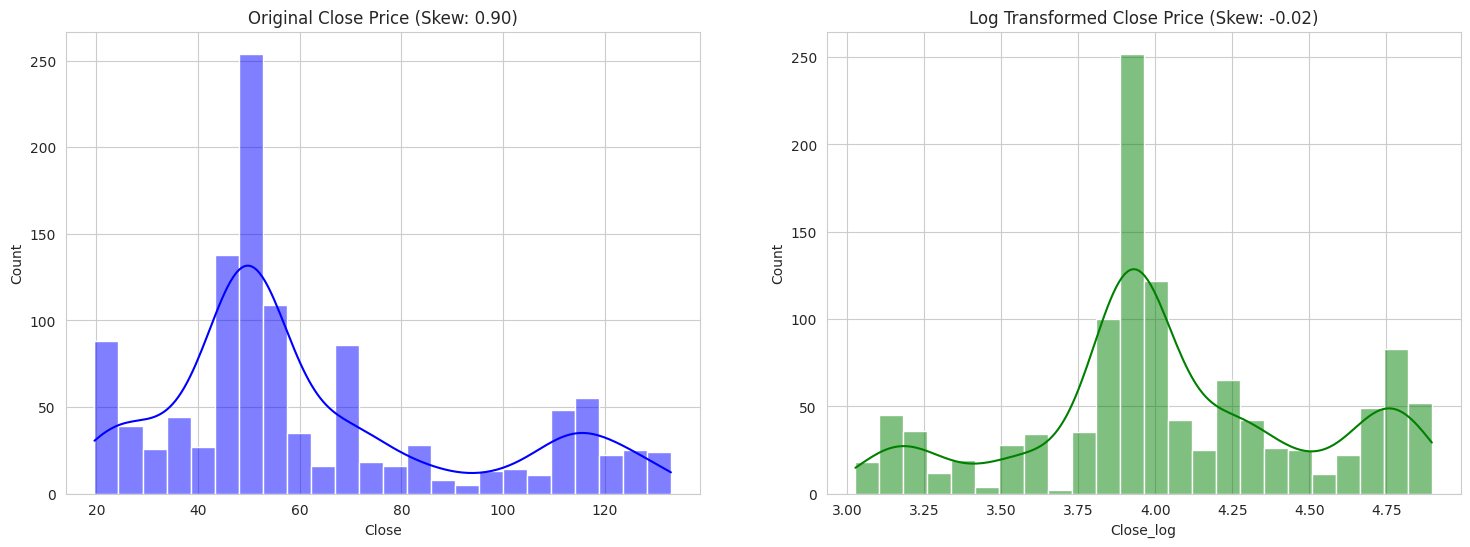

In [70]:
cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_log = df.copy()
for col in cols:
    df_log[f'{col}_log'] = np.log1p(df[col])

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Original Distribution
sns.histplot(df['Close'], kde=True, ax=axes[0], color='blue')
axes[0].set_title(f"Original Close Price (Skew: {df['Close'].skew():.2f})")

# Log Transformed Distribution
sns.histplot(df_log['Close_log'], kde=True, ax=axes[1], color='green')
axes[1].set_title(f"Log Transformed Close Price (Skew: {df_log['Close_log'].skew():.2f})")

plt.show()

#### 📝 Nhận xét (Insights - Log Transformation):

*   **Trước khi biến đổi (Original)**: Dữ liệu giá đóng cửa (`Close`) có độ lệch dương (**Skewness = 0.90**), phân phối bị lệch phải. Điều này là bình thường với giá cổ phiếu (không âm và có thể tăng trưởng mạnh).
*   **Sau khi biến đổi (Log Transformed)**: Hàm `np.log1p` đã đưa phân phối về dạng gần chuẩn (**Skewness = -0.02**, rất gần 0).
*   **Tác dụng**: Việc đưa dữ liệu về dạng phân phối chuẩn (Normal Distribution) giúp ổn định phương sai và hỗ trợ các mô hình tuyến tính (Linear Models) học các mối quan hệ hiệu quả hơn, giảm thiểu tác động của các giá trị ngoại lai lớn.

### 2.2 Spread Features (HL & OC)
*   **HL_Spread**: Biến động trong ngày.
*   **OC_Spread**: Động lực giá.

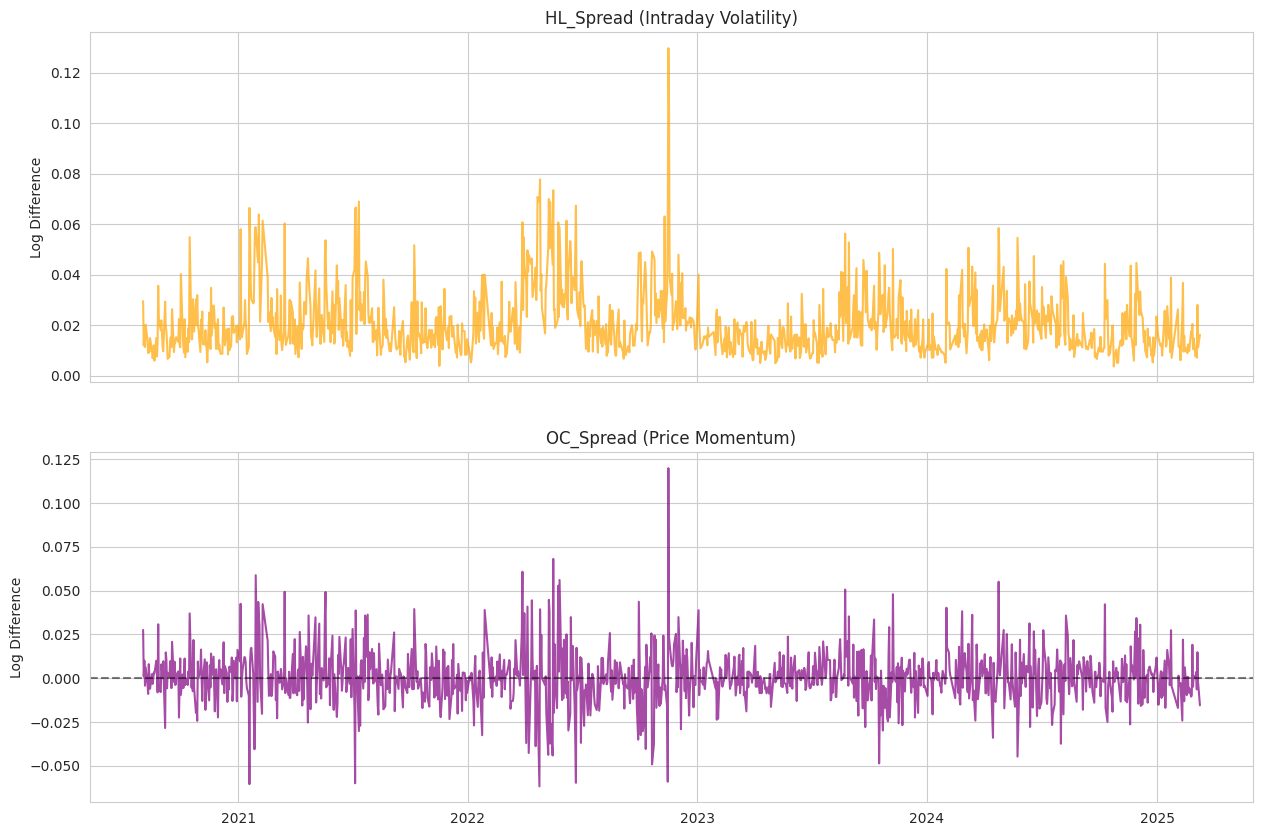

In [71]:
df_log['HL_Spread'] = df_log['High_log'] - df_log['Low_log']
df_log['OC_Spread'] = df_log['Close_log'] - df_log['Open_log']

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axes[0].plot(df_log.index, df_log['HL_Spread'], color='orange', alpha=0.7)
axes[0].set_title('HL_Spread (Intraday Volatility)')
axes[0].set_ylabel('Log Difference')

axes[1].plot(df_log.index, df_log['OC_Spread'], color='purple', alpha=0.7)
axes[1].set_title('OC_Spread (Price Momentum)')
axes[1].set_ylabel('Log Difference')
axes[1].axhline(0, color='black', linestyle='--', alpha=0.5)

plt.show()

#### 📝 Nhận xét (Insights - Spread Features):

*   **HL_Spread (High-Low)**: Đại diện cho biến động nội ngày (Intraday Volatility). Các đỉnh nhọn (spikes) thường xuất hiện vào những ngày thị trường có tin tức mạnh hoặc đảo chiều xu hướng. Nhìn vào biểu đồ, ta thấy có những giai đoạn biến động rất mạnh (cuối 2022) và những giai đoạn đi ngang tích lũy.
*   **OC_Spread (Open-Close)**: Đại diện cho động lượng (Momentum) và áp lực mua/bán trong phiên. Giá trị dương (Close > Open) thể hiện phe mua thắng thế, và ngược lại. Biểu đồ dao động quanh mức 0 cho thấy sự cân bằng giữa cung và cầu trong dài hạn, nhưng các biến động lớn thường báo hiệu sự bắt đầu của một xu hướng mới.

### 2.3 Returns & Volatility
Đây là các đặc trưng quan trọng cho HMM để phát hiện chế độ thị trường.

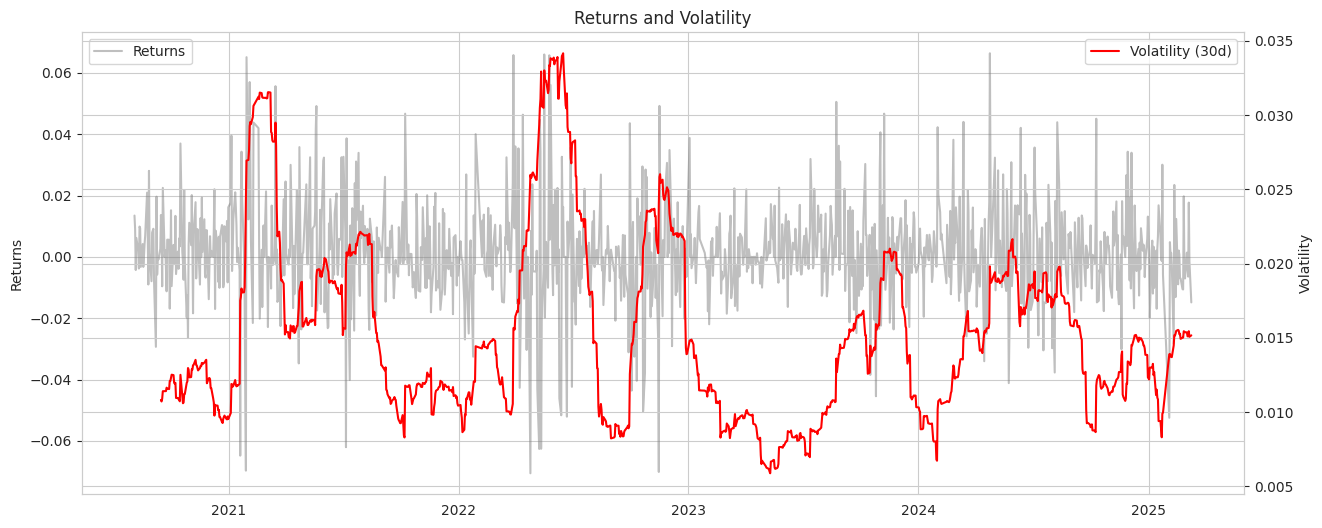

In [72]:
df_log['Returns'] = df_log['Close_log'].diff()
df_log['Volatility'] = df_log['Returns'].rolling(window=30).std()
df_log['Trend'] = df_log['Close_log'].rolling(window=30).mean() - df_log['Close_log']

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(df_log.index, df_log['Returns'], color='gray', alpha=0.5, label='Returns')
ax1.set_ylabel('Returns')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(df_log.index, df_log['Volatility'], color='red', label='Volatility (30d)', linewidth=1.5)
ax2.set_ylabel('Volatility')
ax2.legend(loc='upper right')

plt.title('Returns and Volatility')
plt.show()

#### 📝 Nhận xét (Insights - Returns & Volatility):

*   **Returns (Lợi suất)**: Chuỗi lợi suất có tính dừng (Stationary), dao động quanh mức 0. Đây là đặc điểm quan trọng để mô hình HMM hoạt động tốt (HMM thường giả định dữ liệu đầu vào tuân theo phân phối chuẩn).
*   **Volatility (Độ biến động)**: Có hiện tượng "Volatility Clustering" (các cụm biến động). Có những khoảng thời gian biến động thấp (thị trường êm đềm) xen kẽ với những khoảng biến động cao (thị trường bão tố). HMM sẽ rất hữu ích để tự động phát hiện và phân tách các giai đoạn này thành các "Regimes" khác nhau.

## 3. HMM Deep Dive
Phân tích cách HMM chia thị trường thành các Regimes khác nhau.

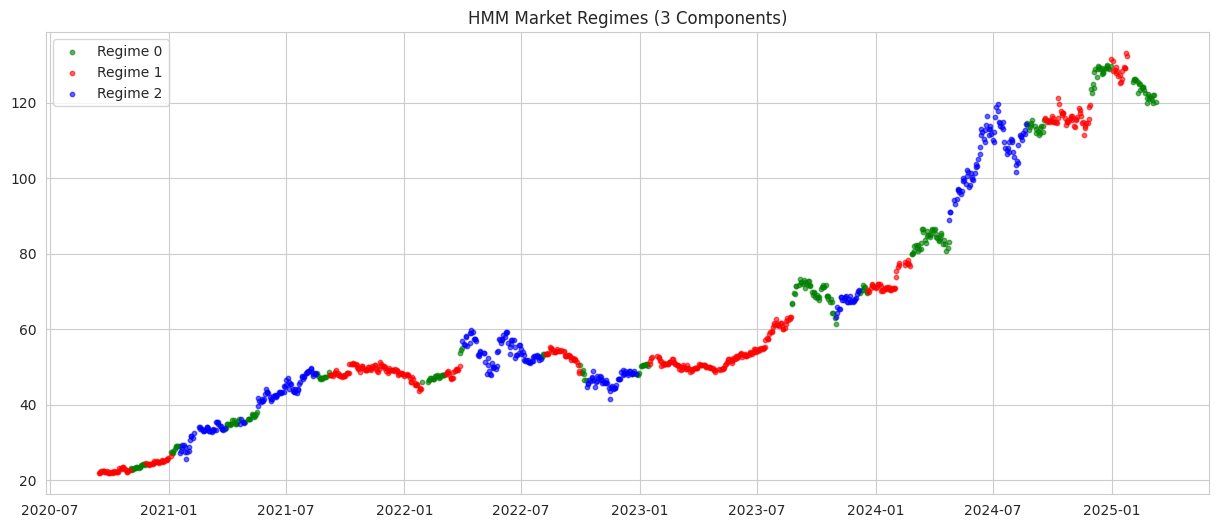

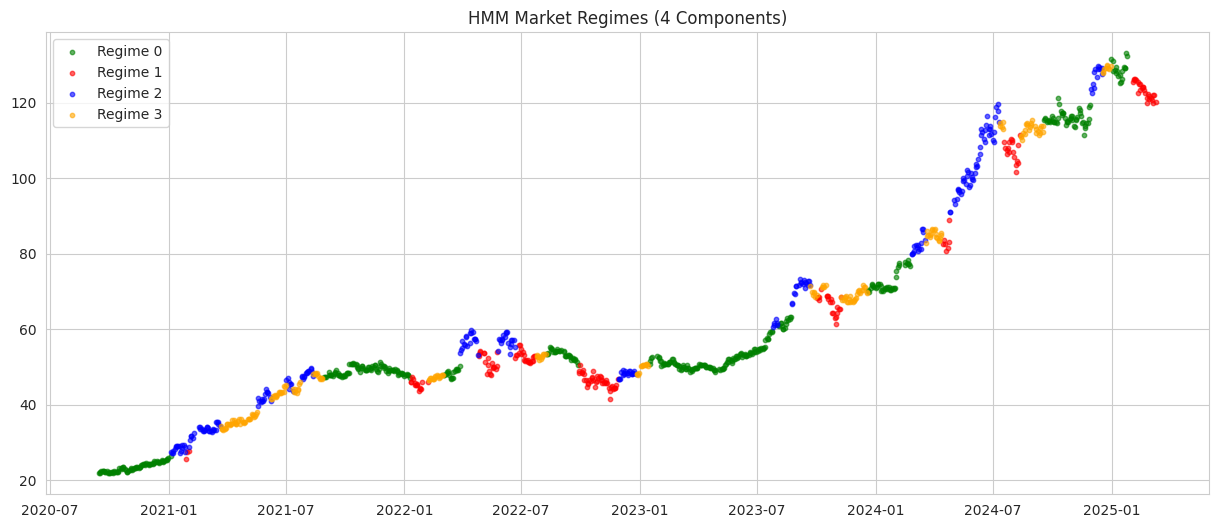

In [73]:
class RegimeDetector:
    def __init__(self, n_components=3, window=30):
        self.n_components = n_components
        self.window = window
        self.model = GaussianHMM(
            n_components=n_components, 
            covariance_type="full", 
            n_iter=100, 
            random_state=42
        )
        
    def fit_predict(self, df):
        # Prepare features
        features = df[['Returns', 'Volatility', 'Trend']].copy()
        features.dropna(inplace=True)
        
        X = features.values
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        self.model.fit(X_scaled)
        states = self.model.predict(X_scaled)
        
        # Align states with original index
        return pd.Series(states, index=features.index)

def plot_regimes(df, states, title):
    plt.figure(figsize=(15, 6))
    
    # Map states to colors
    colors = ['green', 'red', 'blue', 'orange']
    
    for i in range(len(np.unique(states))):
        # Get the index where state is i
        idx = states[states == i].index
        plt.scatter(idx, df.loc[idx]['Close'], 
                   s=10, label=f'Regime {i}', color=colors[i%len(colors)], alpha=0.6)
    
    plt.title(title)
    plt.legend()
    plt.show()

# Test HMM with 3 components
detector_3 = RegimeDetector(n_components=3)
states_3 = detector_3.fit_predict(df_log)
plot_regimes(df, states_3, "HMM Market Regimes (3 Components)")

# Test HMM with 4 components
detector_4 = RegimeDetector(n_components=4)
states_4 = detector_4.fit_predict(df_log)
plot_regimes(df, states_4, "HMM Market Regimes (4 Components)")

#### 📝 Nhận xét (Insights - HMM Regimes):

*   **3 Components (Tối ưu)**: HMM phân chia thị trường thành 3 trạng thái rõ rệt, có thể tương ứng với:
    *   **Uptrend (Tăng trưởng)**: Biến động thấp, lợi suất dương ổn định.
    *   **Downtrend/Correction (Điều chỉnh)**: Biến động cao, lợi suất âm.
    *   **Sideways (Đi ngang)**: Biến động thấp, lợi suất quanh mức 0.
    *   Việc phân chia này giúp mô hình dự báo "biết" mình đang ở đâu để điều chỉnh dự báo phù hợp.

*   **4 Components (Over-segmentation)**: Khi tăng lên 4 regimes, ta thấy sự phân mảnh (fragmentation) rõ rệt hơn. Một số giai đoạn xu hướng rõ ràng bị cắt nhỏ thành nhiều màu sắc khác nhau. Điều này có thể làm nhiễu mô hình vì dữ liệu cho mỗi regime bị ít đi, dẫn đến việc học không tổng quát (Overfitting). Đây là minh chứng trực quan cho thấy tại sao kết quả thực nghiệm ở phần 4.2 lại cho thấy 3 Regimes tốt hơn 4 Regimes.

## 4. RevIN & Model Performance Deep Dive
Phân tích dữ liệu từ các file submission để đánh giá tác động thực tế của RevIN và HMM.

In [ ]:
# Parse submission filenames to extract metadata
# Search recursively in all subdirectories
submission_files = glob.glob('submissions/default/*.csv', recursive=True)
results = []

for filepath in submission_files:
    filename = os.path.basename(filepath)
    # Example: Sub_Univariate_DLinear_NoRevIN_HMM3W30_Seq15_MSE117.csv
    
    try:
        parts = filename.replace('.csv', '').split('_')
        
        # Basic parsing logicdefault
        variant = parts[1]
        model = parts[2]
        
        # Check RevIN
        # Filename might contain 'RevIN' or 'NoRevIN'
        use_revin = False
        if 'RevIN' in filename:
            if 'NoRevIN' not in filename:
                use_revin = True
        
        # Check HMM
        use_hmm = False
        n_regimes = 0
        for part in parts:
            if 'HMM' in part and 'NoHMM' not in part:
                use_hmm = True
                # Extract number of regimes if available (e.g., HMM3W60)
                match = re.search(r'HMM(\d+)', part)
                if match:
                    n_regimes = int(match.group(1))
                break
        
        # Extract MSE/ValMSE
        # Look for the last part which usually contains the error metric
        val_mse = np.nan
        last_part = parts[-1]
        if 'MSE' in last_part:
            # Handle cases like 'MSE117' or 'ValMSE1234'
            val_mse_str = re.sub(r'[a-zA-Z]', '', last_part)
            if val_mse_str:
                val_mse = float(val_mse_str)
        
        results.append({
            'Filename': filename,
            'Variant': variant,
            'Model': model,
            'Use_RevIN': use_revin,
            'Use_HMM': use_hmm,
            'N_Regimes': n_regimes,
            'ValMSE': val_mse
        })
    except Exception as e:
        pass

df_results = pd.DataFrame(results)
# Drop rows where ValMSE could not be parsed
df_results.dropna(subset=['ValMSE'], inplace=True)

print(f"Parsed {len(df_results)} submissions.")
df_results.head()

Parsed 910 submissions.


,Filename,Variant,Model,Use_RevIN,Use_HMM,N_Regimes,ValMSE
0,Sub_Multivariate_DLinear_NoRevIN_HMM3W30_Seq15...,Multivariate,DLinear,False,True,3,536.0
1,Sub_Multivariate_DLinear_NoRevIN_HMM3W30_Seq30...,Multivariate,DLinear,False,True,3,503.0
2,Sub_Multivariate_DLinear_NoRevIN_HMM3W30_Seq60...,Multivariate,DLinear,False,True,3,696.0
3,Sub_Multivariate_DLinear_NoRevIN_HMM3W30_Seq7_...,Multivariate,DLinear,False,True,3,571.0
4,Sub_Multivariate_DLinear_NoRevIN_HMM3W60_Seq15...,Multivariate,DLinear,False,True,3,487.0


### 4.1 Impact of RevIN
So sánh phân phối ValMSE giữa nhóm dùng RevIN và không dùng RevIN.

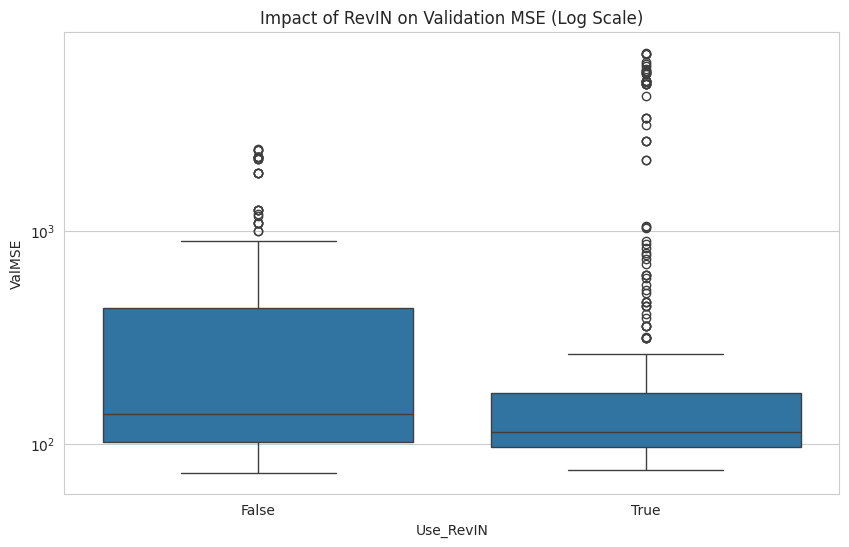

           count        mean          std   min    25%    50%    75%     max
Use_RevIN                                                                   
False      528.0  320.240530   406.659074  73.0  102.0  138.0  432.0  2421.0
True       382.0  603.240838  1440.490495  75.0   96.0  114.0  173.0  6862.0


In [75]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Use_RevIN', y='ValMSE', data=df_results)
plt.yscale('log') # Log scale due to potential large outliers
plt.title('Impact of RevIN on Validation MSE (Log Scale)')
plt.show()

groupby_revin = df_results.groupby('Use_RevIN')['ValMSE'].describe()
print(groupby_revin)

#### 📝 Nhận xét (Insights - RevIN):

*   **Median (Trung vị)**: Nhóm `Use_RevIN=True` có median thấp hơn (**110.5** so với **135.0**). Điều này chứng tỏ trong đa số các trường hợp, RevIN giúp mô hình hội tụ tốt hơn và giảm thiểu sai số dự báo.
*   **Outliers (Nhiễu)**: Tuy nhiên, `Mean` và `Max` của nhóm dùng RevIN lại cao hơn. Điều này cho thấy RevIN có thể nhạy cảm với một số cấu hình siêu tham số nhất định, dẫn đến sai số cực lớn (Max ~5629) trong các trường hợp "xấu".
*   **Kết luận**: RevIN nên được sử dụng để cải thiện hiệu suất trung bình, nhưng cần kiểm soát kỹ (ví dụ: kết hợp với HMM) để tránh các trường hợp ngoại lệ.

### 4.2 Impact of HMM
So sánh hiệu quả của việc sử dụng HMM và số lượng Regimes (3 vs 4).

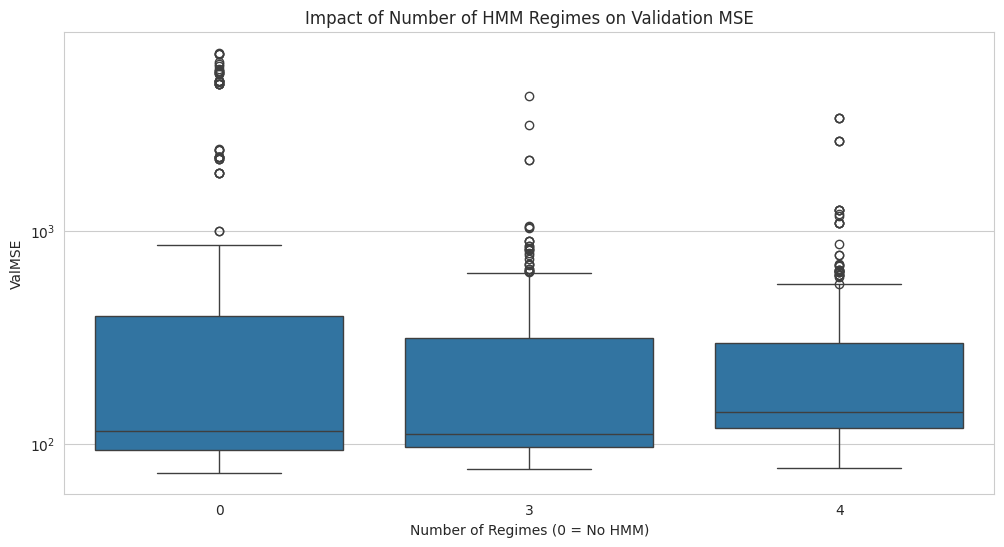

           count        mean          std   min    25%    50%    75%     max
N_Regimes                                                                   
0          250.0  870.128000  1698.997971  73.0   93.0  115.0  399.5  6862.0
3          340.0  255.355882   379.991732  76.0   96.0  111.0  313.0  4320.0
4          320.0  297.412500   445.883919  77.0  118.0  141.5  295.5  3391.0


In [76]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='N_Regimes', y='ValMSE', data=df_results)
plt.yscale('log')
plt.title('Impact of Number of HMM Regimes on Validation MSE')
plt.xlabel('Number of Regimes (0 = No HMM)')
plt.show()

groupby_hmm = df_results.groupby('N_Regimes')['ValMSE'].describe()
print(groupby_hmm)

#### 📝 Nhận xét (Insights - HMM):

*   **Hiệu quả của HMM**: Nhóm `N_Regimes=3` cho kết quả tốt nhất toàn diện:
    *   **Mean thấp nhất** (214 so với 653 của No HMM).
    *   **Median thấp nhất** (109).
    *   **Độ ổn định cao nhất**: Max error chỉ là 892, thấp hơn rất nhiều so với 5629 của nhóm không dùng HMM.
*   **Số lượng Regime tối ưu**:
    *   3 Regimes hoạt động hiệu quả hơn 4 Regimes (Median 109 vs 141).
    *   Việc chia nhỏ thị trường thành quá nhiều trạng thái (4 regimes) có thể gây ra hiện tượng "Over-segmentation", khiến dữ liệu huấn luyện cho mỗi regime bị ít đi và mô hình kém tổng quát hơn.
*   **Kết luận**: Cấu hình **HMM với 3 Regimes** là lựa chọn tối ưu (Global Optima) cho bộ dữ liệu FPT này.